In [ ]:
# Lunar Lander gym environment.
! pip install gym gym[box2d]
! pip install box2d

# Visualization of the animation.
! pip install ipywidgets

In [1]:
import pickle
import random
import gc

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import gymnasium as gym

from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from collections import deque
from statistics import mean

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Disable progress bar during training
class DisableProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        tqdm._instances.clear()

gc.collect()

0

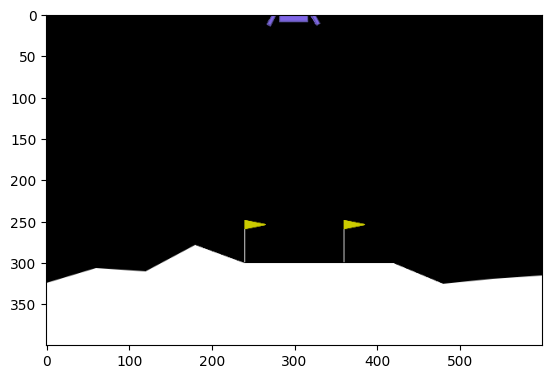

In [2]:
seed = 888

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Lunar Lander environment initialization
env = gym.make("LunarLander-v3", render_mode='rgb_array', enable_wind=False)
obs = env.reset()
image = env.render()
plt.imshow(image)

In [ ]:
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

def create_model():
    """Construct the critic network with q-values per action as output"""
    model = keras.Sequential([
        layers.Input(shape=(N_STATES,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu", name='prunable'),           #v1&v2: 64
        layers.Dense(N_ACTIONS, activation='linear', name='output')
    ])

    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prunable (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,788 (10.89 KB)

 Trainable params: 2,788 (10.89 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, new_state):
        self.buffer.append((state, action, reward, new_state))

    def sample_batch(self, batch_size):
        #indices = random.sample(range(len(self.buffer)), batch_size)
        #batch = [self.buffer[i] for i in indices]
        batch = random.sample(self.buffer, batch_size)
        #states, actions, rewards, new_states = zip(*batch)
        #return (np.array(states), np.array(actions), np.array(rewards), np.array(new_states))
        return batch
    
    def size(self):
        return len(self.buffer)
    

In [5]:
GAMMA = .95
DECAY_FACTOR = .99995    #v1:.99995, v2:.9997
BATCH_SIZE = 64
MAX_EPISODES = 200      #v1:200, v2:150
ACCEPTABLE_AVERAGE_SCORE_THRESHOLD = 0      #200
MAX_ACCEPTABLE_AVG_SCORE_COUNTER = 20       #100

tf.keras.utils.disable_interactive_logging()

def Trainer(m, callbacks=[]):
    #memory = []
    buffer = ReplayBuffer(max_size=10000)       #v2:5000
    last_50_scores = deque(maxlen=50)
    epsilon = 1.0
    acceptable_avg_score_counter = 0

    def choosePlay(state):
        nonlocal epsilon
        random_action = lambda: np.random.randint(N_ACTIONS)

        def predicted_action():
            q_values = m(tf.expand_dims(state, 0))
            action = tf.squeeze(tf.argmax(q_values, axis=-1))
            return action.numpy()

        action =  random_action() if np.random.random() <= epsilon else predicted_action()
        epsilon = max(0.1, epsilon * DECAY_FACTOR)      #v2:0.05

        return action

    def obs_to_state(obs):
        if isinstance(obs, tuple):
            obs = obs[0]  # Extract the observation array
        
        obs_array = np.array(obs, dtype=np.float32)
        #print(obs_array)
        
        return obs_array

    def play(state):
        action = choosePlay(state)
        result = env.step(action)
        #print(f"env.step(action) returned: {result}")  # Debugging

        # Adjust unpacking for 5 values
        if len(result) == 5:
            obs, reward, done, _, _ = result
        elif len(result) == 4:
            obs, reward, done, _ = result  # Handle older gym versions
        else:
            raise ValueError(f"Unexpected output from env.step(action): {result}")

        #obs, reward, done, _ = env.step(action)
        new_state = obs_to_state(obs)

        return action, reward, new_state, done

    def train_step(state):
        # Play to gain experience
        action, reward, new_state, done = play(state)
        new_state = np.zeros_like(state) if done else new_state

        # Store experience in the memory bank
        buffer.store(state, action, reward, new_state)

        # test
        if buffer.size() > 0:  # Ensure enough samples are in the buffer
            actual_batch_size = min(buffer.size(), BATCH_SIZE)
            #states, actions, rewards, new_states = buffer.sample_batch(actual_batch_size)
            #print(buffer.sample_batch(actual_batch_size))
            batch = np.asarray(buffer.sample_batch(actual_batch_size), dtype=object)
            
            
            '''
            # Predict Q-values for current and next states
            q_s_a = m.predict(states)  # Q(s,a)
            q_s_a_next = m.predict(new_states)  # Q(s',a)
            
            # Update Q-values using Bellman Equation
            for i in range(BATCH_SIZE):
                if np.array_equal(new_states[i], np.zeros(N_STATES)):  # Terminal state
                    q_s_a[i, actions[i]] = rewards[i]
                else:
                    q_s_a[i, actions[i]] = rewards[i] + GAMMA * np.amax(q_s_a_next[i])

            m.fit(states, q_s_a, batch_size=BATCH_SIZE, verbose=0, callbacks=[DisableProgressBar(), *callbacks])

            # Train the network with a batch of the gained experience
            '''
            #batch = np.asarray(random.sample(memory, min(len(memory), BATCH_SIZE)), dtype=object)
            q_s_a = m.predict(np.stack(batch[:, 0], axis = 0))  #Q(s,a)
            q_s_a_next = m.predict(np.stack(batch[:, 3], axis = 0))  #Q(s',a)

            for item_id in range(batch.shape[0]):
                if np.array_equal(batch[item_id, 3], np.zeros(N_STATES)):
                    q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2]
                else:
                    q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2] + GAMMA*np.amax(q_s_a_next[item_id, :])

            m.fit(np.stack(batch[:, 0], axis = 0), q_s_a, batch_size=BATCH_SIZE, verbose=0, callbacks=[DisableProgressBar(), *callbacks])
        
        return new_state, reward, done

    def record_episode(episode_id, step_id, score, reward, results):
        nonlocal acceptable_avg_score_counter

        # Update the last 100 scores queue with the latest score
        last_50_scores.append(score)

        # Collect episode results
        mean_last_50_scores = mean(last_50_scores)
        results.append((step_id, reward, score, mean_last_50_scores))

        # Increment the counter if the episode scores past the acceptance threshold
        # Reset the counter if the episode falls below the acceptance threshold
        if mean_last_50_scores > ACCEPTABLE_AVERAGE_SCORE_THRESHOLD:
            acceptable_avg_score_counter += 1
        else:
            acceptable_avg_score_counter = 0

        print(
            'Episode:', episode_id,
            'Steps:', step_id,
            'Score:', score,
            'Reward:', reward,
            '50_rolling_average:', mean_last_50_scores,
            'Acceptable Average Score Count:', acceptable_avg_score_counter,
        )

    def train(episodes=MAX_EPISODES, steps=1000):        #v1&v2: 500
        results = []

        for episode_id in range(episodes):
            obs = env.reset()
            state = obs_to_state(obs)
            score = 0

            for step_id in range(steps):
                state, reward, done = train_step(state)
                score += reward

                if done:
                    record_episode(episode_id, step_id, score, reward, results)
                    break

            if not done:
                record_episode(episode_id, 1000, score, reward, results)

            # Terminate training if the average score meet the acceptance threshold
            # for MAX_ACCEPTABLE_AVG_SCORE_COUNTER episodes in sequence.
            if acceptable_avg_score_counter >= MAX_ACCEPTABLE_AVG_SCORE_COUNTER:
                break

            gc.collect()

        return results

    return train

trainer = Trainer(model)
results = trainer()

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(results, f)

model.save_weights('lunar_lander.weights.h5')

Episode: 0 Steps: 82 Score: -130.63542245570727 Reward: -100 50_rolling_average: -130.63542245570727 Acceptable Average Score Count: 0
Episode: 1 Steps: 85 Score: -160.91199486873572 Reward: -100 50_rolling_average: -145.7737086622215 Acceptable Average Score Count: 0
Episode: 2 Steps: 97 Score: -21.631324705916626 Reward: -100 50_rolling_average: -104.39291401011987 Acceptable Average Score Count: 0
Episode: 3 Steps: 108 Score: -116.49940025745492 Reward: -100 50_rolling_average: -107.41953557195363 Acceptable Average Score Count: 0
Episode: 4 Steps: 78 Score: -146.47976098979973 Reward: -100 50_rolling_average: -115.23158065552285 Acceptable Average Score Count: 0
Episode: 5 Steps: 97 Score: -304.47356210109933 Reward: -100 50_rolling_average: -146.77191089645225 Acceptable Average Score Count: 0
Episode: 6 Steps: 97 Score: -320.4899388261932 Reward: -100 50_rolling_average: -171.5887720292724 Acceptable Average Score Count: 0
Episode: 7 Steps: 65 Score: -133.0369686239311 Reward: -1

Label(value='Training Results')

,Steps,Reward,Score,R50_Score,Done,Crashed
0,82,-100.000000,-130.635422,-130.635422,False,True
1,85,-100.000000,-160.911995,-145.773709,False,True
2,97,-100.000000,-21.631325,-104.392914,False,True
3,108,-100.000000,-116.499400,-107.419536,False,True
4,78,-100.000000,-146.479761,-115.231581,False,True
...,...,...,...,...,...,...
195,1000,2.673140,-60.219646,-94.486331,False,False
196,1000,0.158754,-106.975463,-95.993901,False,False
197,1000,-2.635586,-80.543525,-96.965431,False,False
198,1000,-0.220662,-80.251129,-97.613183,False,False


Successes: 5 Crashes: 133 Timeouts: 62


Label(value='Top Scores')

,Steps,Reward,Score,R50_Score,Done,Crashed
157,648,100.0,218.338840,-49.541282,True,False
158,559,100.0,207.969341,-40.124839,True,False
150,692,100.0,207.450301,-49.874924,True,False
149,483,100.0,174.728553,-56.678971,True,False
130,751,100.0,158.376213,-53.982476,True,False


Label(value='Bottom Scores')

,Steps,Reward,Score,R50_Score,Done,Crashed
5,97,-100.0,-304.473562,-146.771911,False,True
131,716,-100.0,-307.866565,-58.689870,False,True
6,97,-100.0,-320.489939,-171.588772,False,True
19,121,-100.0,-358.521407,-160.910899,False,True
21,85,-100.0,-403.799483,-169.714589,False,True


Label(value='Training Benchmarks')

,Start,End,Count,Successes,Crashes,Timeouts
0,0,200,109,0,109,0
1,200,300,7,0,7,0
2,300,500,8,1,7,0
3,500,700,10,3,7,0
4,700,1000,4,1,3,0


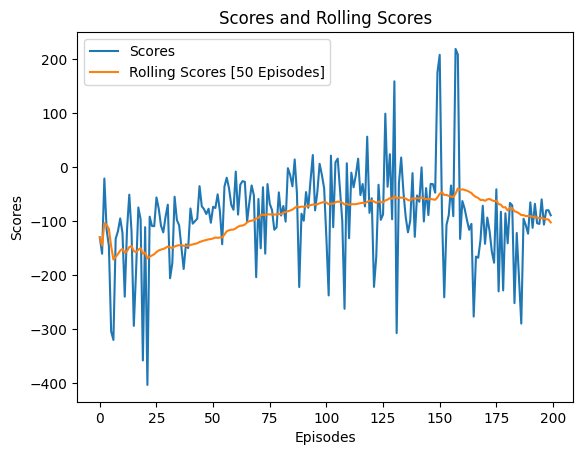

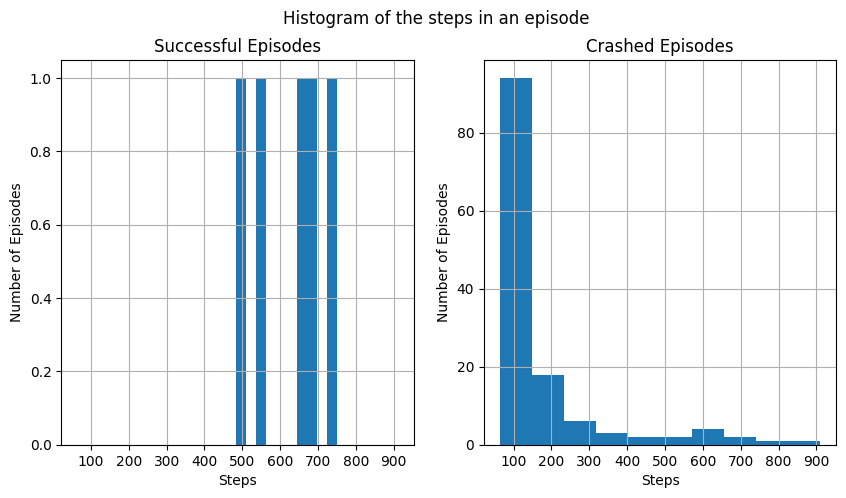

In [6]:
from ipywidgets import Label

def load_results(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        columns = ['Steps', 'Reward', 'Score', 'R50_Score']
        return pd.DataFrame(results, columns=columns)

def show_results(df):
    df['Done'] = df['Reward'] == 100
    df['Crashed'] = df['Reward'] == -100

    # Plot rolling scores
    plt.plot(df['Score'], label='Scores')
    plt.plot(df['R50_Score'], label='Rolling Scores [50 Episodes]')
    plt.legend()
    plt.title('Scores and Rolling Scores')
    plt.xlabel('Episodes')
    plt.ylabel('Scores')

    display(Label('Training Results'), df)

def summarize_results(file):
    df = load_results(file)
    show_results(df)

    # Display Summary
    successes = len(df[df['Done'] == True])
    crashes = len(df[df['Crashed'] == True])
    timeouts = len(df.loc[(df['Crashed'] == False) & (df['Done'] == False)])
    print('Successes:', successes, 'Crashes:', crashes, 'Timeouts:', timeouts)

    # Top and bottom scores
    sorted_scores = df.sort_values('Score', ascending=False)
    display(Label('Top Scores'), sorted_scores.head())
    display(Label('Bottom Scores'), sorted_scores.tail())

    steps_benchmarks = [0, 200, 300, 500, 700, 1000]
    benchmark_df = pd.DataFrame(columns=['Start', 'End', 'Count', 'Successes', 'Crashes', 'Timeouts'])

    for bm in range(1, len(steps_benchmarks)):
        start, end = steps_benchmarks[bm - 1], steps_benchmarks[bm]
        range_cond = (df['Steps']>=start) & (df['Steps']<end)

        count = len(df.loc[range_cond])
        successes = len(df.loc[range_cond & df['Done'] == True])
        crashes = len(df.loc[range_cond & df['Crashed'] == True])
        timeouts = len(df.loc[range_cond & (df['Crashed'] == False) & (df['Done'] == False)])

        benchmark_df.loc[bm-1] = (start, end, count, successes, crashes, timeouts)

    # Training Benchmarks
    display(Label('Training Benchmarks'), benchmark_df)

    # Episode Steps Histogram
    successes_df = df.loc[df['Done'] == True]['Steps']
    crashes_df = df.loc[df['Crashed'] == True]['Steps']

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
    successes_df.hist(ax=axes[0])
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Number of Episodes')
    axes[0].set_title('Successful Episodes')
    axes[0].set_xticks(range(0, 1000, 100))

    crashes_df.hist(ax=axes[1])
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Number of Episodes')
    axes[1].set_title('Crashed Episodes')
    fig.suptitle('Histogram of the steps in an episode')

#summarize_results('sample_lunar_lander.results.pkl')
summarize_results('lunar_lander.results.pkl')

In [9]:
def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render()
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))

    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,int(2e9)))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

def trial_run(m):
    def obs_to_state(obs):
        if isinstance(obs, tuple):
            obs = obs[0]  # Extract the observation array
        
        obs_array = np.array(obs, dtype=np.float32)
        #print(obs_array)
        
        return obs_array

    def predicted_action(state):
        q_values = m(tf.expand_dims(state, 0))
        action = tf.squeeze(tf.argmax(q_values, axis=-1))
        return action.numpy()

    obs = env.reset()
    score = 0
    frames = []

    for step_id in range(1000):
        state = obs_to_state(obs)
        action = predicted_action(state)
        result = env.step(action)
        #obs, reward, done, _ = env.step(action)
        if len(result) == 5:
            obs, reward, done, _, _ = result
        elif len(result) == 4:
            obs, reward, done, _ = result  # Handle older gym versions
        else:
            raise ValueError(f"Unexpected output from env.step(action): {result}")
        score += reward
    



        # Save visuals
        save_visuals(env, frames)

        if done:
            print('Finished with total score:', score, 'in steps: ', step_id)
            break

    print('Total Score:', score, 'Done:', done)
    return frames

#model.load_weights('sample_lunar_lander.weights.h5')
container, frames = {}, trial_run(model)
save_frames_as_gif(container, 0, frames)

Total Score: -89.9887112734711 Done: False


In [10]:
import ipywidgets as ipyw

def create_expanded_button(description, button_style):
    return ipyw.Button(description=description, button_style=button_style, layout=ipyw.Layout(height='auto', width='auto'))

def image_widget(file):
    with open(file, "rb") as file:
        image = file.read()
        #return Image(value=image, width=w, height=h)
        return ipyw.Image(value=image)

def image_label_widget(title, file):
    image = image_widget(file)
    label = ipyw.Label(value=title)
    layout = ipyw.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid')
    box = ipyw.Box(children=[image, label], layout=layout)
    return box

def display_gifs_grid(images, cols=5):
    rows = (len(images)+cols-1) // cols
    grid = ipyw.GridspecLayout(rows, cols)

    for index, image in images.items():
        gcol = index%cols
        grow = index//cols

        grid[grow, gcol] = image_label_widget(str(index), image)

    return grid

display_gifs_grid(container, cols=1)

GridspecLayout(children=(Box(children=(Image(value=b'GIF89aX\x02\x90\x01\x87\x00\x00\xff\xff\xff\xfc\xfc\xfc\x…